In [2]:
%pip install matplotlib numpy requests pandas seaborn tensorflow pydot

Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

2025-06-27 20:18:30.083479: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 20:18:30.685916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-27 20:18:30.686114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-27 20:18:30.754655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-27 20:18:30.926402: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 20:18:30.928744: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [ ]:
url = (
    "https://archive-api.open-meteo.com/v1/archive"
    "?latitude=30.4202&longitude=-9.5982"
    "&start_date=2000-01-01&end_date=2025-05-19"
    "&hourly=temperature_2m,dewpoint_2m,relative_humidity_2m,precipitation,pressure_msl,windspeed_10m,cloudcover"
    "&timezone=auto"
)

data = requests.get(url).json()
df = pd.DataFrame(data["hourly"])
df.to_csv("./agadir_weather.csv", index=False)


In [3]:
df = pd.read_csv("./agadir_weather.csv")

In [4]:
df['datetime_utc'] = pd.to_datetime(df['time'])

In [5]:
# imputing the missing value in temperature feature with mean.
df['temperature_2m'].fillna(df['temperature_2m'].mean(), inplace=True)

In [6]:
df['temperature_2m'].isna().sum()
# filled all missing values with mean()

0

In [7]:
str(df['datetime_utc'][0])

'2000-01-01 00:00:00'

In [8]:
# a function to extract year part from the whole date
def get_year(x):
  return x[0:4]

In [9]:
# a function to extract month part from the whole date
def get_month(x):
  return x[5:7]

In [10]:
# making two new features year and month
df['year'] = df['datetime_utc'].apply(lambda x: get_year(str(x)))
df['month'] = df['datetime_utc'].apply(lambda x: get_month(str(x)))

In [11]:
df['year']

0         2000
1         2000
2         2000
3         2000
4         2000
          ... 
222451    2025
222452    2025
222453    2025
222454    2025
222455    2025
Name: year, Length: 222456, dtype: object

In [12]:
temp_year = pd.crosstab(df['year'], df['month'], values=df['temperature_2m'], aggfunc='mean')

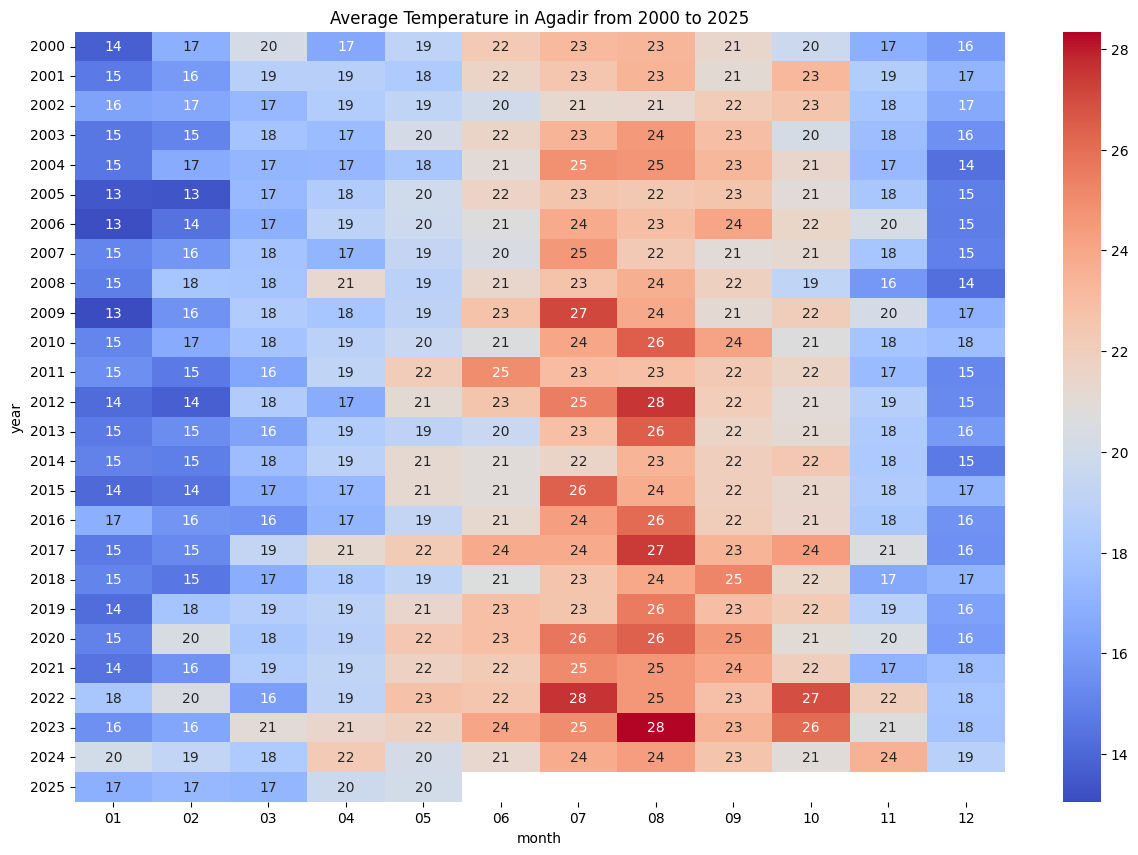

In [13]:
plt.figure(figsize=(15, 10))
sns.heatmap(temp_year, cmap='coolwarm', annot=True)
plt.title("Average Temperature in Agadir from 2000 to 2025")
plt.show()

In [14]:
df.rename(columns={
    "temperature_2m": "_tempm",
}, inplace=True)

In [15]:
df.head()

,time,_tempm,dewpoint_2m,relative_humidity_2m,precipitation,pressure_msl,windspeed_10m,cloudcover,datetime_utc,year,month
0,2000-01-01T00:00,14.6,13.1,91.0,0.0,1019.7,5.1,0.0,2000-01-01 00:00:00,2000,01
1,2000-01-01T01:00,15.0,13.3,90.0,0.0,1019.9,4.3,0.0,2000-01-01 01:00:00,2000,01
2,2000-01-01T02:00,13.3,12.1,92.0,0.0,1019.8,5.4,7.0,2000-01-01 02:00:00,2000,01
3,2000-01-01T03:00,11.5,10.6,94.0,0.0,1019.5,6.6,29.0,2000-01-01 03:00:00,2000,01
4,2000-01-01T04:00,11.0,9.8,92.0,0.0,1019.7,7.1,9.0,2000-01-01 04:00:00,2000,01


In [16]:
# taking only temperature feature as values and datetime feature as index in the dataframe for time series forecasting of temperature
data = pd.DataFrame(list(df['_tempm']), index=df['datetime_utc'], columns=['temp'])

In [17]:
data

,temp
datetime_utc,
2000-01-01 00:00:00,14.600000
2000-01-01 01:00:00,15.000000
2000-01-01 02:00:00,13.300000
2000-01-01 03:00:00,11.500000
2000-01-01 04:00:00,11.000000
...,...
2025-05-17 19:00:00,19.817105
2025-05-17 20:00:00,19.817105
2025-05-17 21:00:00,19.817105


In [18]:
# resampling data with date frequency for time series forecasting
data = data.resample('D').mean()

In [19]:
data.temp.isna().sum()

0

In [20]:
data.fillna(data['temp'].mean(), inplace=True)

In [21]:
data.temp.isna().sum()

0

In [22]:
data.shape

(9269, 1)

In [23]:
data

,temp
datetime_utc,
2000-01-01,14.308333
2000-01-02,13.766667
2000-01-03,13.241667
2000-01-04,13.075000
2000-01-05,12.462500
...,...
2025-05-13,20.500000
2025-05-14,22.858333
2025-05-15,22.550000


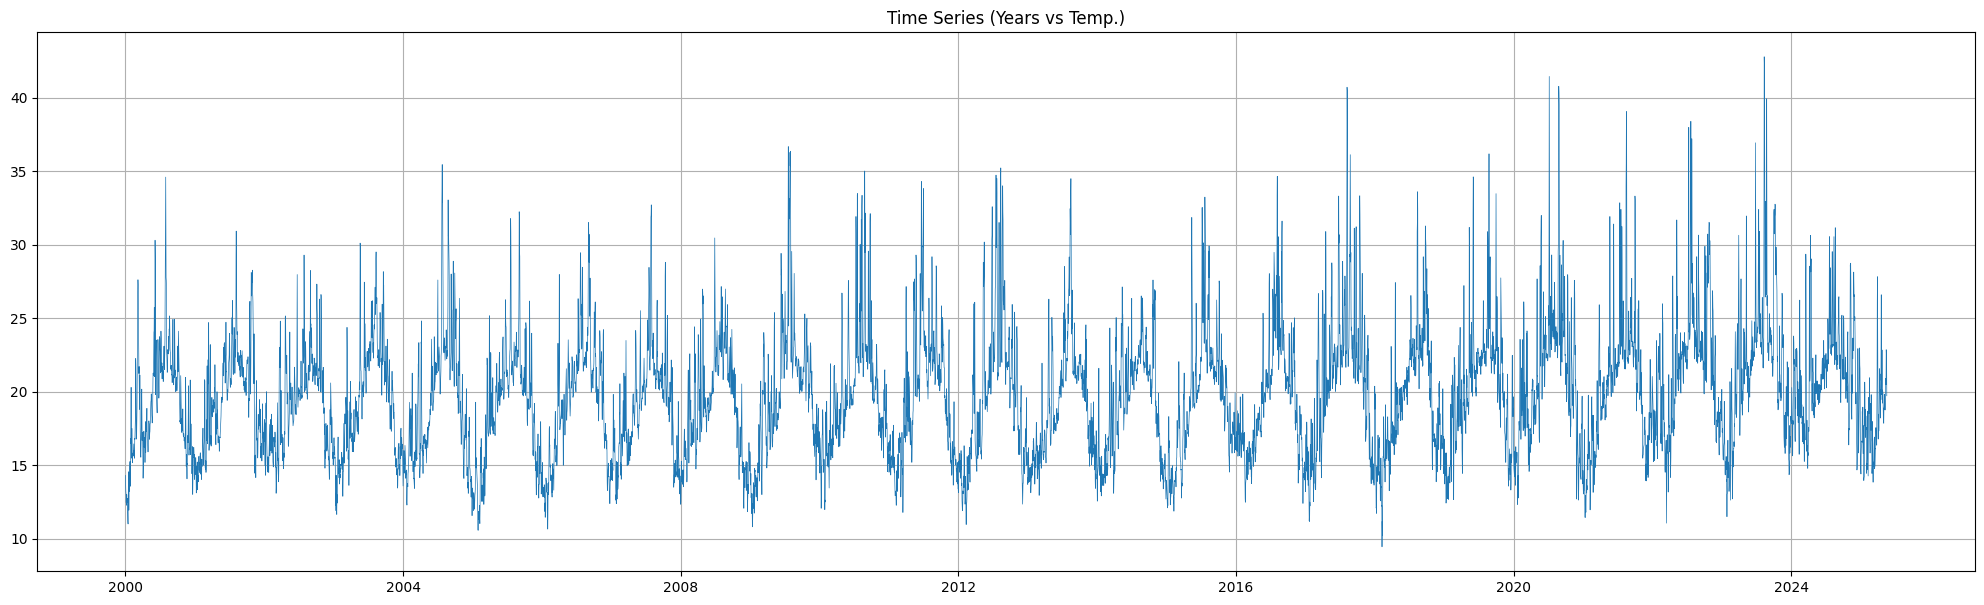

In [24]:
plt.figure(figsize=(25, 7))
plt.plot(data, linewidth=.5)
plt.grid()
plt.title("Time Series (Years vs Temp.)")
plt.show()

In [25]:
# Scaling data to get rid of outliers
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(-1,1))
data_scaled = scalar.fit_transform(data)

In [26]:
data_scaled

array([[-0.70889083],
       [-0.74140303],
       [-0.77291484],
       ...,
       [-0.21420533],
       [-0.21720645],
       [-0.38357808]])

In [27]:
data_scaled.shape

(9269, 1)

In [28]:
steps = 30
inp = []
out = []
for i in range(len(data_scaled)- (steps)):
    inp.append(data_scaled[i:i+steps])
    out.append(data_scaled[i+steps])

In [29]:
inp=np.asanyarray(inp)
out=np.asanyarray(out)

In [30]:
x_train = inp[:7300,:,:]
x_test = inp[7300:,:,:]    
y_train = out[:7300]    
y_test= out[7300:]

In [31]:
inp.shape

(9239, 30, 1)

In [32]:
x_train.shape

(7300, 30, 1)

In [33]:
x_test.shape

(1939, 30, 1)

In [34]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, RepeatVector, LSTM, Dropout, Bidirectional, Dense

model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(30,1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(30))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 256)           768       
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 128)           65664     
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 128)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 1792)          0         
 r)                                                              
                                                                 
 lstm (LSTM)                 (None, 30, 100)           7

In [36]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=7, mode='min')

history = model.fit(
    x_train,
    y_train,
    epochs=300,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/300
229/229 [==============================] - 78s 284ms/step - loss: 0.0925
Epoch 2/300
229/229 [==============================] - 59s 257ms/step - loss: 0.0137
Epoch 3/300
229/229 [==============================] - 61s 267ms/step - loss: 0.0107
Epoch 4/300
229/229 [==============================] - 61s 265ms/step - loss: 0.0092
Epoch 5/300
229/229 [==============================] - 59s 257ms/step - loss: 0.0090
Epoch 6/300
229/229 [==============================] - 54s 236ms/step - loss: 0.0089
Epoch 7/300
229/229 [==============================] - 51s 221ms/step - loss: 0.0082
Epoch 8/300
229/229 [==============================] - 61s 268ms/step - loss: 0.0080
Epoch 9/300
229/229 [==============================] - 56s 245ms/step - loss: 0.0080
Epoch 10/300
229/229 [==============================] - 84s 369ms/step - loss: 0.0079
Epoch 11/300
229/229 [==============================] - 80s 348ms/step - loss: 0.0081
Epoch 12/300
229/229 [==============================] - 52s 225

In [37]:
model.save("./ml.h5")

/home/souhaib/test/test-project-iot-watch/iot-env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
model = load_model('ml.h5')

In [39]:
x_test

array([[[-0.4367888 ],
        [-0.46830061],
        [-0.38777041],
        ...,
        [-0.79292235],
        [-0.70989121],
        [-0.73665124]],

       [[-0.46830061],
        [-0.38777041],
        [-0.5775916 ],
        ...,
        [-0.70989121],
        [-0.73665124],
        [-0.80067525]],

       [[-0.38777041],
        [-0.5775916 ],
        [-0.59009629],
        ...,
        [-0.73665124],
        [-0.80067525],
        [-0.65136926]],

       ...,

       [[-0.35875953],
        [-0.39952482],
        [-0.17669126],
        ...,
        [-0.31299237],
        [-0.33725147],
        [-0.19569839]],

       [[-0.39952482],
        [-0.17669126],
        [ 0.02863574],
        ...,
        [-0.33725147],
        [-0.19569839],
        [-0.21420533]],

       [[-0.17669126],
        [ 0.02863574],
        [-0.29773665],
        ...,
        [-0.19569839],
        [-0.21420533],
        [-0.21720645]]])

In [40]:
predict = model.predict(x_test)

61/61 [==============================] - 6s 83ms/step


In [41]:
predict = scalar.inverse_transform(predict)

In [42]:
predict

array([[14.514164],
       [15.368496],
       [14.85275 ],
       ...,
       [22.159502],
       [20.498499],
       [20.529083]], dtype=float32)

In [43]:
Ytesting = scalar.inverse_transform(y_test)

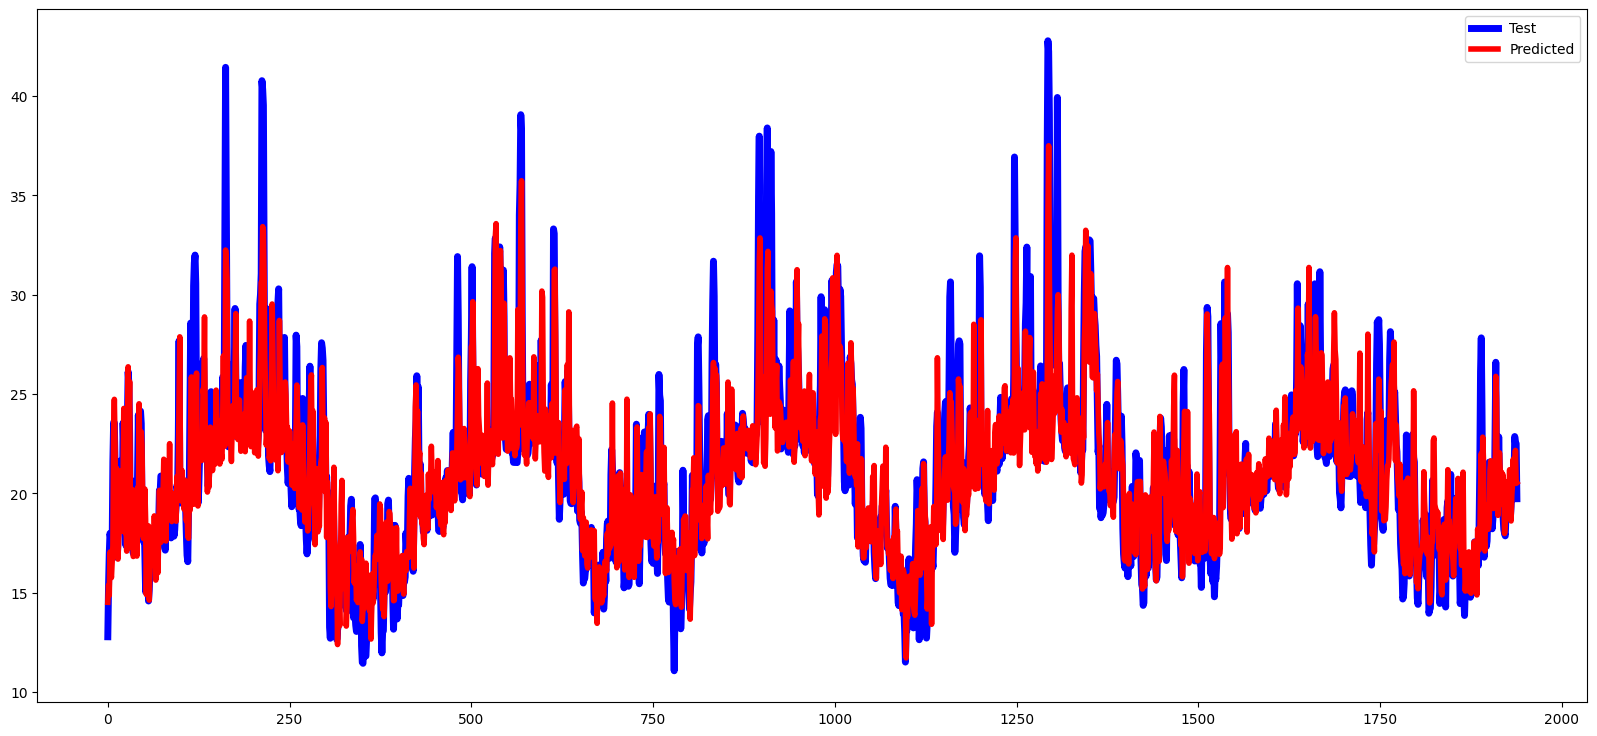

In [44]:
plt.figure(figsize=(20,9))
plt.plot(Ytesting , 'blue', linewidth=5)
plt.plot(predict,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Ytesting, predict)

5.5488123123322275